## Author: Jacquelyn Witte

In [10]:
import os
#os.system('jupyter nbconvert --to html --no-input Jacquie-Witte_CapstoneBlogpost_final.ipynb')

import earthpy as et
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

from geopandas import GeoDataFrame
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.4)

%matplotlib inline

In [2]:
def leastsq(x, y, method=3):
    """
    5 methods to compute least squares fit.

    Reference: https://github.com/sbird/spb_common/blob/master/leastsq.py
    Compute the least squares fit to y = beta x + alpha,
    using one of the 5 methods outlined in
    http://adsabs.harvard.edu/abs/1990ApJ...364..104I
    Method 1 minimises distance from Y given X (ie, the standard least squares fit)
    Method 2 minimises distance from X given Y
    Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
    Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
    Method 5 is the geometric mean of the slopes from methods 1 and 2.
    Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
    (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)

    Parameters
    ----------
    x, y: numeric array

    Returns
    -------
    (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    # Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    # Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    # These formulas are taken from Table 1 of Isobe et al, page 3
    # Minimise distance from Y given X
    beta1 = sxy/sxx
    # Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    # Minimise distance from X given Y
    beta2 = syy/sxy
    # Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    # Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif) *
                    (ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = bvar1
    if method == 2:
        beta = beta2
        bvar = bvar2
    if method == 3:
        # OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        # Variance
        prefac = beta**2 / ((beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = (beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 
               * covb12 + beta1p1**2 * bvar2)
        bvar = prefac*var

    if method == 4:
        # Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy) *
                    np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * (bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2)

    if method == 5:
        # Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        # Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y, y)
        xx = np.subtract.outer(x, x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        # Can't find a formula for the variance
        bvar = 0

    # The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

<center>
<font size="2">
<h1>Exploring patterns between soil moisture and rainfall in the western US using satellite observations</h1>
</center>

***

<center>
    <h1>Predicting landslides is important! </h1>
<center>

><h3>Landslides are a serious geologic hazard common to many areas in the US and Canada. There are negative economic, transportation, and habitat impacts resulting from landslides.</h3>

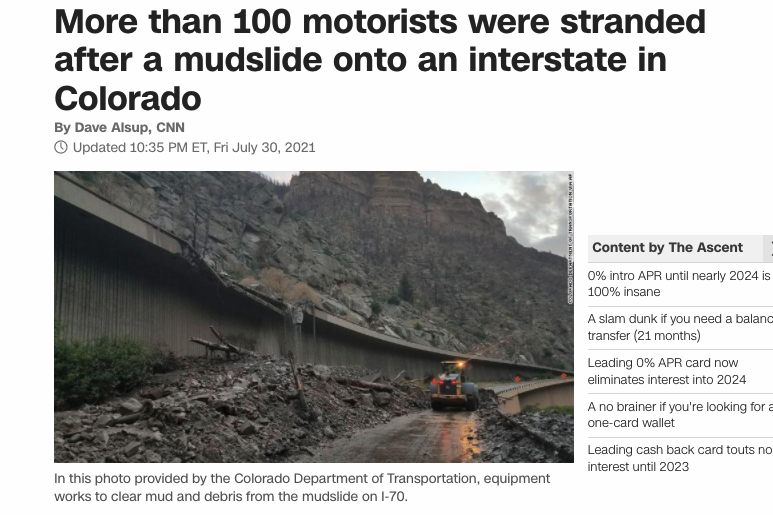 
<br>Image Source: https://www.cnn.com/2021/07/30/us/colorado-motorists-trapped-mudslide/index.html

><h3>There are climate change implications where drought or heavier rains affect the number and severity of landslides.</h3>

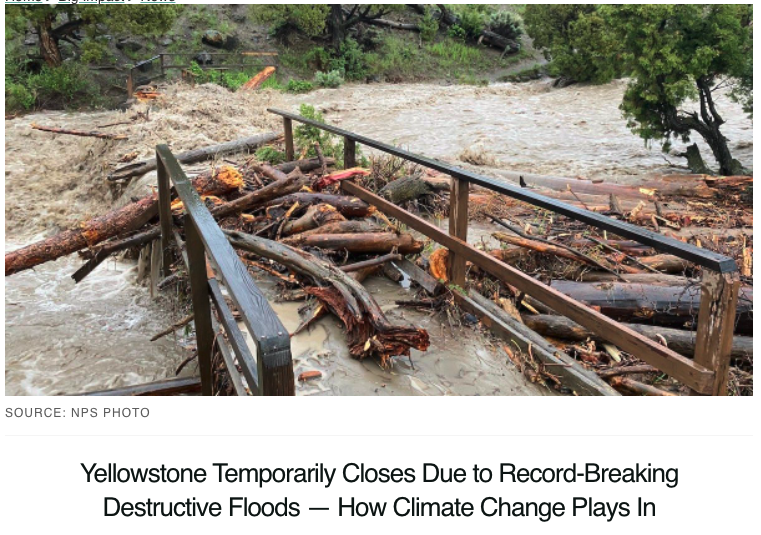
<br>Image Source: https://www.greenmatters.com/p/why-is-yellowstone-flooding

***

## Objective


<font size="2">
The goal of this project is to examine the relationship between soil moisture and precipitation during rainfall-triggered landslide events. 
<br>
<ol>
    <li>What does that relationship look like? 
    <li>What information can we learn from relating soil moisture to precipitation during a rainfall-triggered landslide?
</ol>

## Primary Study Region: Colorado, USA

<font size="2">
Colorado experiences many landslides each year because of its steep terrain. Some of them occur in remote areas that are difficult to monitor, with most occurring west of the Front Range. Damage from landslides in Colorado is estimated to be millions of dollars per year. 
<br><br>
Towns and cities in Colorado's mountainous or hilly terrain are growing and spreading as populations move into these popular destination areas. It is important to understand the potential exposure to landslide hazards, and how counties can maintain optimal land-use and infrastructure to reduce the costs of living with landslides.

In [11]:
data_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'capstone-landslides-soilmoisture',
                        'data', 
                        'glc_smap_esa_gpm_2015-2020_Colorado.csv')
landslide_df = pd.read_csv(data_file, index_col='date')

# Georeference the locations to plot on Folium
geometry = [Point(xy) for xy in zip(landslide_df['glc_lon'], 
                                    landslide_df['glc_lat'])]
crs = 'epsg:4326'
glc_co_epsg4326 = GeoDataFrame(landslide_df, crs=crs, geometry=geometry)

# Create a symbology dictionary that maps "type" to color. 
triggers = np.unique(glc_co_epsg4326['landslide_trigger'])
colors = ['red', 'green', 'blue', 'orange','lightgray']
points_symb = dict(zip(triggers,colors))

# ------- Map the Landslide events -----------------------------
# Create Title
loc = 'Rainfall-triggered Landslides in Colorado (2015 - 2020)'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m2 = folium.Map([39.0, -105.27], zoom_start=7, tiles='Stamen Terrain')

for i, loc in glc_co_epsg4326.iterrows():
    folium.Marker(location=[loc['glc_lat'], loc['glc_lon']],
                  icon=folium.Icon(color=points_symb[loc['landslide_trigger']],
                                   prefix='glyphicon', icon='off')).add_to(m2)
    
Dict = {'cr': {'raintype': 'Continuous Rain',
            'loc': [40.5, -103],
            'color': 'red',
            'textloc': [40.5, -102.7]},
        'dp': {'raintype': 'Downpour',
            'loc': [40, -103],
            'color': 'green',
            'textloc': [40, -102.7]},
        'rain': {'raintype': 'Rain',
            'loc': [39.5, -103],
            'color': 'dodgerblue',
            'textloc': [39.5, -102.7]},
        }
    
for key in Dict.keys():
    folium.CircleMarker(location=Dict[key]['loc'], radius=6,
                        color=Dict[key]['color'],
                        fill_color=Dict[key]['color'],
                        fill_opacity=1.0).add_to(m2)
    folium.Marker(
        location=Dict[key]['textloc'],
        icon=folium.DivIcon(
            html=f"""<b>{Dict[key]['raintype']}</b>""")
    ).add_to(m2)

#Add Title
m2.get_root().html.add_child(folium.Element(title_html))
m2

## What types of landslides and precipitation are occurring during these events?


<font size="2">
The histograms below rely on the NASA Global Landslide Catalog that documents rainfall-triggered landslides around the world. The GLC considers all types of mass movements triggered by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The GLC has been compiled since 2007 at NASA Goddard Space Flight Center.<br><br>
Note that unfortunately landslide events are not as well cataloged after 2018. However, the GLC remains the best source for landslide today.


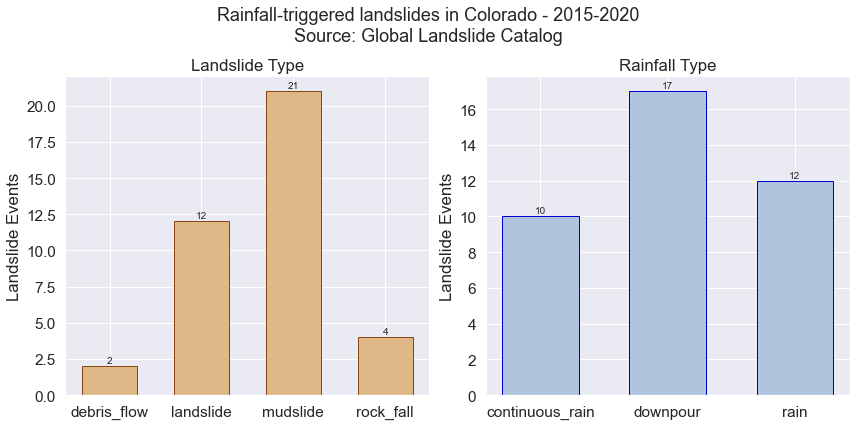

In [17]:
stack_size = []
labels_size = []
for i, data in landslide_df.groupby('landslide_category'):
    labels_size.append(i)
    stack_size.append(data['landslide_category'].count())

stack_trig = []
labels_trig = []
for i, data in landslide_df.groupby('landslide_trigger'):
    labels_trig.append(i)
    stack_trig.append(data['landslide_trigger'].count())

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
width = 0.6

t1 = 'Rainfall-triggered landslides in Colorado - 2015-2020\n'
t2 = 'Source: Global Landslide Catalog'
f.suptitle(t1+t2, fontsize=18)

bars = ax1.bar(labels_size, stack_size, width,
               color='burlywood', edgecolor='saddlebrown')
ax1.set(ylabel='Landslide Events',
        title='Landslide Type')
ax1.bar_label(bars, padding=1)


bars = ax2.bar(labels_trig, stack_trig, width,
               color='lightsteelblue', edgecolor='mediumblue')
ax2.set(ylabel='Landslide Events',
        title='Rainfall Type')
ax2.bar_label(bars, padding=1)

f.tight_layout()

## Main Finding

### There is a linear relationship between soil moisture and precipitation for Colorado

<font size="2">
<ul>
    <li> The scatter plot below is the sum of all the rain for a week prior to a landslide event versus the maximum soil moisture for that past week. 
    <li>The linear relationship means that as precipitation increases, so does soil moisture.
    <li>However, the type of landslide seems randomly distributed indicating limitations in identifying different hydrologic signatures that can cause landslides.
    <li>In the future, we can use this linear relationship to help models improve their accuracy in predicting future landslides over Colorado.
</ul>

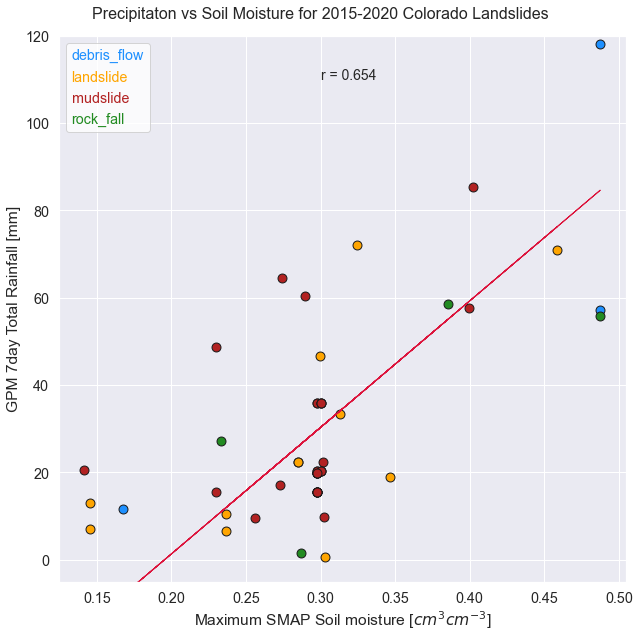

In [9]:
colors = ['dodgerblue',  'orange', 'firebrick', 'forestgreen', 'k', 'purple']
category = dict(zip(np.unique(landslide_df['landslide_category']), colors))

# Create a scatter plot
fig, ax1 = plt.subplots(figsize=(9, 9))

# GPM daily precip vs SMAP & ESA
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'], df['gpm_7day_accum_mm'],
                        edgecolor='k', s=80.0,
                        color=category[cat])
            ax1.scatter(df['smap_sm'], df['imerg_7day_accum_mm'],
                        edgecolor='k', s=80.0,
                        color=category[cat])

# calculate the linear trend
idx_daily = (np.isfinite(landslide_df['smap_sm'])
       & np.isfinite(landslide_df['gpm_7day_accum_mm'])
       )
# defining the variables
x = landslide_df['smap_sm'][idx_daily].tolist()
y = landslide_df['gpm_7day_accum_mm'][idx_daily].tolist()

idx_30min = (np.isfinite(landslide_df['smap_sm'])
       & np.isfinite(landslide_df['imerg_7day_accum_mm'])
       )

x = x + landslide_df['smap_sm'][idx_30min].tolist()
y = y + landslide_df['imerg_7day_accum_mm'][idx_30min].tolist()

# Remove anomalously high precip value
yy = y[0:5] + y[7:-1]
xx = x[0:5] + x[7:-1]

# Calculate the OLR Bisector fit
intercept, slope, var = leastsq(xx, yy, method=3)
trend_mean_text = 'slope: '+str('{:.2f}'.format(slope)) + \
    ', y: '+str('{:.2f}'.format(intercept))

# plot the linear trend
ax1.plot(landslide_df['smap_sm'],
         intercept + slope*landslide_df['smap_sm'],
         color='crimson',
         linewidth=1.0)

ax1.set(xlabel='Maximum SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Total Rainfall [mm]')
ax1.set_ylim(-5, 120)

# Add the correlation
corr, p_value = st.pearsonr(xx, yy)
ax1.text(0.3, 110, "r = {:.3f}".format(corr), fontsize=14)

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 Colorado Landslides',
    fontsize=16
)


plt.tight_layout()

### Challenges

<font size="2">
There are limitations in using the GLC.
<ul>
    <li>Complications arise because we rely on accurate landslide locations and definitions of the type of landslide (just calling it a landslide ignores a myriad of types) and the rainfall type that triggers a landslide. These are not always accurately defined.
    <li>Not all landslides are documented so we can think of the Global Landslide Catalog as representing a fraction of all landslide events. 
    <li>The landslide categories of `debris flow` and `mudslide` is a misnomer. Debris flows are also known as mudslides. 
</ul> 
    
The resolution and data gaps in the satellite retrievals are another limitation.
<ul>
    <li>The SMAP soil moisture contain gaps and only started measuring in 2015. 
    <li>The daily GPM rainfall data contains very few measurement gaps but the time resolution is course. Conversely, the 30-minute data has higher accuracy of rainfall depth during a landslide event, but there are numerous data gaps. The balance was to merge both measurements in the scatter plot below. 
</ul>

### Data Sources

<font size="2">
<ul>
    <li>These observations come from NASA's Global Precipitation Measurement (GPM) and the Soil Moisture Active Passive (SMAP) satellites. 
    <li>The nearest-neighbor method is used to extract GPM measurements closest to the landslide location.
    <li>SMAP measurements represent the maximum value within 0.3 degrees around the Landslide event.
</ul>

### The scatter plot above shows there are a significant number of landslides for which there is both low rainfall and low soil moisture. Let's explore this some more.

<font size="2">
Below is a scatter plot of the Ksat (Saturated Hydraulic Conductivity) vs soil moisture.
<ul>
    <li>Ksat is a measure of how easily water can pass through soil or rock. The units represent the infiltration rate once the ground has reached 100% saturation.
</ul>
<br>
The scatter plot below shows that most of the ksat values are positive indicating saturated flow is occurring. In most soils this situation takes place when about 95% of the total pore space is filled with water.
<br><br>
The soil type over most landslides is sand or gravel based (mean is 43%$\pm$17%), followed by silt (mean is 36%$\pm$10%), and clay (mean is 20%$\pm$8%). 
<ul>
    <li>Sand is the largest mineral particle and it has more pore space between its particles than silt or clay. Silt particles are smaller than sand, but larger than clay particles.
    <li>Soils with this percentage combination can have moderately high runoff potential when thoroughly wet. 
</ul>
    
    
### Data Sources

- Ksat and soil type data come from the Probabilistic Remapping of SSURGO (POLARIS) soil properties — a database of 30-m probabilistic soil property maps over the US. 
    - We use the mode statistics at 5-15 cm depth 
    - The nearest-neighbor method is used to extract Ksat measurements closest to the landslide location.
- Interpretation of the Ksat and porosity analysis was found in [this study](https://www.nrcs.usda.gov/wps/PA_NRCSConsumption/download?cid=nrcseprd1327274&ext=pdf)

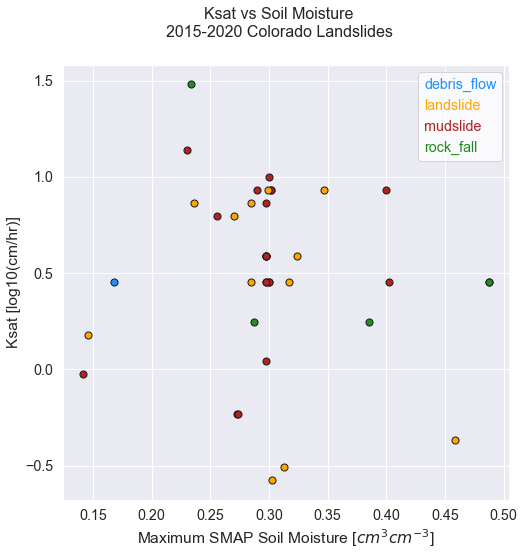

In [6]:
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

# GPM daily precip vs SMAP & ESA
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax.scatter(df['smap_sm'], df['ksat_log10cm/hr'],
                        edgecolor='k', s=50.0,
                        color=category[cat])

# Add legend
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# Add titles
ax.set(xlabel='Maximum SMAP Soil Moisture [$cm^3 cm^{-3}$]',
       ylabel='Ksat [log10(cm/hr)]')

# add an overall caption
fig.suptitle(
    'Ksat vs Soil Moisture\n2015-2020 Colorado Landslides',
    fontsize=16
);

***

### Git Hub Resources

- Additional analyses and information that incorporates other soil moisture and precipitation variables can be found in the [The GitHub landslides-soilmoisture repository](https://github.com/jacquiewitte/capstone-landslides-soilmoisture)

### Data References

[NASA Global Landslide Catalog (2015-2020)](https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog/h9d8-neg4)
<br>Citation: https://doi.org/10.1007/s11069-009-9401-4


[NASA SMAP Enhanced L3 Radiometer Global Daily 9 km EASE-Grid Soil Moisture V004](https://search.earthdata.nasa.gov)
<br>Citation: https://doi.org/10.5067/NJ34TQ2LFE90.


[GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 degree V06](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGDL_06/summary?keywords=%22IMERG%20late%22)
<br>Citation: https://doi.org/10.5067/GPM/IMERGDL/DAY/06


GPM IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V06

This capstone uses 30 min GPM IMERG data pre-assembled and saved in CSV format by Dr. Elsa Culler (CU-Boulder). The beauty of this data set is that precipitation values have been subset and co-located with GLC landslides by their ID, latitude, and longitude. Request this data set by emailing Elsa.Culler@colorado.edu
<br>Citation: https://doi.org/10.5067/GPM/IMERG/3B-HH/06


[POLARIS 30m Probabilistic Soil Properties US](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ksat/mode/5_15/)
<br>Citation: https://doi.org/10.1029/2018WR022797